In [ ]:
# -*- coding: utf-8 -*-

# En primer lugar cargamos nuestro Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

# Bibliotecas y funciones de las mismas a emplear

In [ ]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap
from timeit import default_timer
import sys

# Chi Cuadrado
from scipy.stats import chisquare

#No mostramos los warnings
import warnings

warnings.filterwarnings("ignore")

#De sklearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR, LinearSVR
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics.pairwise import euclidean_distances, rbf_kernel  # Para funciones de base radial
from sklearn.cluster import MiniBatchKMeans
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import learning_curve


# Para trabajar con ficheros
import os

np.random.seed(777)

# Funciones auxiliares

Estas funciones serán de utilidad en el desarrollo del preprocesado para los datos. En particular, todas las funciones auxiliares que aparecen más abajo están dedicadas a la generación de características


In [ ]:
# Clase que representa la generación de característica de distancia mínima entre cada par de CETOs en cada instancia
class DistanciaMinima:
    
    def __init__(self):
        pass
    
    #Cálculo de las características a añadir
    def fit(self,X,y):
        self.mindist = np.zeros(X.shape[0])       # Aquí guardaremos la distancia máxima entre cada par de CETOs para cada instancia
        
        for k in range(X.shape[0]):             # Para cada instancia
          dist = []
          for i in range(16):                   # Calculamos las distancias entre cada par distinto de CETOs
            for j in range(i+1,16):
              dist.append(norm([(X[k,i] - X[k,j]), (X[k,i+16] - X[k,j+16])]))

          self.mindist[k] = np.min(np.array(dist))  # Añadimos la distancia mínima
        return self

    # Añadimos la propia característica a los datos
    def transform(self,X):
        return np.c_[X, self.mindist]


# Clase que representa la generación de característica de distancia máxima entre cada par de CETOs en cada instancia
class DistanciaMaxima:
    
    def __init__(self):
        pass
    
    #Cálculo de la característica a añadir
    def fit(self,X,y):
        self.maxdist = np.zeros(X.shape[0])        # Aquí guardaremos la distancia máxima entre cada par de CETOs para cada instancia
        
        for k in range(X.shape[0]):                 # Para cada instancia
          dist = np.zeros((X.shape[1], X.shape[1]))
          for i in range(16):                           
            for j in range(i+1,16):
              dist[i,j] = norm([(X[k,i] - X[k,j]), (X[k,i+16] - X[k,j+16])])  # Calculamos las distancias entre cada par distinto de CETOs
          self.maxdist[k] = np.max(dist)                 # Añadimos la distancia máxima
        return self

    # Añadimos la propia característica a los datos
    def transform(self,X):
        return np.c_[X, self.maxdist]


# Clase que representa la generación de característica de la media de las distancias mínimas entre cada CETOs con los demás
class MediaDistanciasMinimas:
    
    def __init__(self):
        pass
    
    #Cálculo de la característica a añadir
    def fit(self,X,y):
        self.mindist = np.zeros(X.shape[0])       # Aquí guardaremos las características a añadir
        
        for k in range(X.shape[0]): # Para cada instancia
          mindists = np.zeros(16) # Aquí almacenaremos las distancias mínimas entre cada CETO y cualquier otro
          for i in range(16):         # Para cada CETO en dicha instancia
            min = float('inf')
            for j in range(16):
              curdist = norm([(X[k,i] - X[k,j]), (X[k,i+16] - X[k,j+16])])
              if curdist < min and not i == j:
                min = curdist                     # Calculamos la distancia mínima entre el CETO fijo y cualquier otro
            mindists[i] = min                     # La almacenamos
          self.mindist[k] = np.mean(mindists)     # Añadimos la media de las distancias mínimas calculadas
        return self

    # Añadimos la propia característica a los datos
    def transform(self,X):
        return np.c_[X, self.mindist]


# Clase que representa la generación de característica de la media de las distancias máximas entre cada CETOs con los demás
class MediaDistanciasMaximas:
    
    def __init__(self):
        pass
    
    #Cálculo de la característica a añadir
    def fit(self,X,y):
        self.maxdist = np.zeros(X.shape[0])       # Aquí guardaremos las características a añadir
        
        for k in range(X.shape[0]):     # Para cada instancia
          maxdists = np.zeros(16) # Aquí almacenaremos las distancias mínimas entre cada CETO y cualquier otro
          for i in range(16):       # Para cada CETO en dicha instancia
            max = 0
            for j in range(16):
              curdist = norm([(X[k,i] - X[k,j]), (X[k,i+16] - X[k,j+16])])
              if curdist > max and not i == j:
                max = curdist                   # Calculamos la distancia máxima entre el CETO fijo y cualquier otro
            maxdists[i] = max                   # La almacenamos
          self.maxdist[k] = np.mean(maxdists)   # Añadimos la media de las distancias máximas calculadas
        return self

    # Añadimos la propia característica a los datos
    def transform(self,X):
        return np.c_[X, self.maxdist]

  
# Clase simple que representa el cálculo de la característica 'Distancia media al centroide de los puntos'
class DistanciaMediaACentroide:
    
    def __init__(self):
        pass
    
    #Cálculo de la característica a añadir
    def fit(self,X,y):
        self.distcent = np.zeros(X.shape[0])       # Aquí guardaremos la nueva característica a añadir

        for k in range(X.shape[0]):               # Para cada instancia

          # Calculamos las coordenadas del centroide
          x_centr = np.mean(X[k,0:16])
          y_centr = np.mean(X[k,16:32])

          dists = np.zeros(16)
          for i in range(16):
            dists[i] = norm([(X[k,i]-x_centr), (X[k,i+16]-y_centr)])  # Nos quedamos con la distancia de cada CETO al centroide

          self.distcent[k] = np.mean(dists)         # Por último, guardamos la media de esas distancias

        return self

    #Método para aplicar la transformación calculada en fit.
    def transform(self,X):
        return np.c_[X, self.distcent]


# Clase simple que representa el cálculo de la característica de la varianza en las coordenadas de los CETOs
class Varianza:
    
    def init(self):
        pass
    
    #Cálculo de la característica a añadir
    def fit(self,X,y):
        self.vars = np.zeros(X.shape[0])       # Aquí guardaremos la nueva característica a añadir

        for k in range(X.shape[0]):              # Para cada instancia

            # Ponemos los datos en forma de pares [x,y]
            pares = []
            for i in range(16):
                pares.append([X[k,i], X[k,i+16]])
            
            self.vars[k] = np.var(pares)      # Calculamos y guardamos la varianza de las coordeanadas
        return self
    
    #Método para aplicar la transformación calculada en fit.
    def transform(self,X):
        return np.c_[X, self.vars]


# Clase para generar una característica haciendo un test estadístico de uniformidad Chi^2 sobre las coordenadas X de cada CETO en una instancia
# La hipótesis nula H0 es que las coordenadas X de los CETOs con una distribución Uniforme sobre las posiciones X

# que representa el p-value del test Chi cuadrado
class Chi2x:
    
    def init(self):
        pass
    
    # Método para encontrar las variables con las que nos vamos a quedar
    def fit(self,X,y):
        self.p = np.zeros(X.shape[0])

        for k in range(X.shape[0]):
          freq = np.zeros(3)
          
          for i in range(16):
            if X[k][i]<566/3:
              freq[0] = freq[0]+1
            elif X[k][i]<2*566/3:
              freq[1] = freq[1]+1
            else:
              freq[2] = freq[2]+1     
          
          chisq, p2 = chisquare(freq) # f_exp por defecto asume que las frecuencias son equivalentes

          self.p[k] = p2

        return self
    
    def transform(self,X):
        return np.c_[X, self.p]

# Clase simple que representa el p-value del test Chi cuadrado con una distribución Uniforme sobre las posiciones Y
class Chi2y:
    
    def init(self):
        pass
    
    # Método para encontrar las variables con las que nos vamos a quedar
    def fit(self,X,y):
        self.p = np.zeros(X.shape[0])

        for k in range(X.shape[0]):
          freq = np.zeros(3)
          
          for i in range(16,32):
            if X[k][i]<566/3:
              freq[0] = freq[0]+1
            elif X[k][i]<2*566/3:
              freq[1] = freq[1]+1
            else:
              freq[2] = freq[2]+1     
          
          chisq, p2 = chisquare(freq) # f_exp por defecto asume que las frecuencias son equivalentes

          self.p[k] = p2

        return self
    
    def transform(self,X):
        return np.c_[X, self.p]



# Clase simple que representa el p-value del test Chi cuadrado con una distribución Uniforme
class Chi2Diagonal:
    
    def init(self):
        pass
    
    # Método para encontrar las variables con las que nos vamos a quedar
    def fit(self,X,y):
        self.p = np.zeros(X.shape[0])

        for k in range(X.shape[0]):      #Para cada instancia
          freq = np.zeros(3)

          for i in range(16):           #Para cada CETO en dicha instancia
            # Le asignamos una clase en función de su posición
            if (X[k][i]<2*566/3 and X[k][i+16]>566/3) and not (X[k][i]>566/3 and X[k][i+16]<2*566/3):
              freq[0] = freq[0]+1
            elif (X[k][i]>566/3 and X[k][i+16]<2*566/3) and not (X[k][i]<2*566/3 and X[k][i+16]>566/3):
              freq[1] = freq[1]+1
            else:
              freq[2] = freq[2]+1     
          
          chisq, p2 = chisquare(freq) # f_exp por defecto asume que las frecuencias son equivalentes

          self.p[k] = p2

        return self
    
    def transform(self,X):
        return np.c_[X, self.p]

Vamos a crear una función para leer los archivos. Leeremos sólo el archivo de datos de Sydney porque los conjuntos de datos contienen muestras que no se extraen de una misma distribución. Por lo tanto nos limitaremos a hacer el estudio con un conjunto de datos, el cual tiene un número suficiente de instancias como para poder obtener resultados significativos (alrededor de 70000)

In [ ]:
def leerArchivos(path):
  """
  
  """
  data_tasmania = pd.read_csv(path + "/Tasmania_Data.csv")
  data_adelaide = pd.read_csv(path + "/Adelaide_Data.csv")
  data_sydney = pd.read_csv(path + "/Sydney_Data.csv")
  data_perth = pd.read_csv(path + "/Perth_Data.csv")


  return data_tasmania, data_adelaide, data_sydney, data_perth

  #return data_sydney

Leemos los datos

In [ ]:
testsize=0.20
#path = '/content/drive/MyDrive/AA/WECs_DataSet'
path = "."
data_tasmania, data_adelaide, data_sydney, data_perth = leerArchivos(path)
X_tasmania = data_tasmania.iloc[:,:32].values
y_tasmania = data_tasmania.iloc[:,-1].values
X_adelaide = data_adelaide.iloc[:,:32].values
y_adelaide = data_adelaide.iloc[:,-1].values
X_perth = data_perth.iloc[:,:32].values
y_perth = data_perth.iloc[:,-1].values


X = data_sydney.iloc[:,:32].values
y = data_sydney.iloc[:,-1].values



X_train_tasmania, X_test_tasmania, y_train_tasmania, y_test_tasmania = train_test_split(X_tasmania,y_tasmania, test_size = testsize)
X_train_adelaide, X_test_adelaide, y_train_adelaide, y_test_adelaide = train_test_split(X_adelaide,y_adelaide, test_size = testsize)
X_train_perth, X_test_perth, y_train_perth, y_test_perth = train_test_split(X_perth,y_perth, test_size = testsize)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = testsize)

print("Cantidad total de datos del archivo Sydney_Data.csv: ", X.shape[0])
print("Cantidad total de datos en entrenamiento: ", X_train.shape[0])
print("Cantidad total de datos en test: ", X_test.shape[0])


print("Media de potencia de los datos de Sydney: ", np.mean(y_train))
print("Media de potencia de los datos de Tasmania: ", np.mean(y_train_tasmania))
print("Media de potencia de los datos de Adelaide: ", np.mean(y_train_adelaide))
print("Media de potencia de los datos de Perth: ", np.mean(y_train_perth))





Cantidad total de datos del archivo Sydney_Data.csv:  71999
Cantidad total de datos en entrenamiento:  57599
Cantidad total de datos en test:  14400
Media de potencia de los datos de Sydney:  1486302.964840744
Media de potencia de los datos de Tasmania:  3760250.7301586834
Media de potencia de los datos de Adelaide:  1410051.386172558
Media de potencia de los datos de Perth:  1394490.262902724


# Análisis exploratorio de los datos

Vamos a mostrar un resumen estadístico inicial de los mismos utilizando la orden describe.

In [ ]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
count,57599.000000,57599.000000,57599.000000,57599.00000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000,57599.000000
mean,323.987456,318.643331,248.316824,273.29726,363.913155,270.697487,268.204627,250.623493,257.508938,263.881558,314.212835,276.679784,273.371300,340.067221,280.497450,273.611649,336.857362,236.064587,256.975686,288.367043,305.646930,336.451657,263.832894,253.856309,285.318026,295.238204,276.332835,306.153740,254.431201,251.208222,303.871908,270.284419
std,201.025991,200.344355,207.938141,202.73004,165.274775,222.065775,210.235833,191.486786,193.844553,203.195215,192.640101,205.585842,198.447795,189.676131,196.855693,193.364113,191.198836,186.784320,191.431372,190.374024,192.343564,188.880379,189.980429,183.786368,198.003240,194.962869,208.588042,206.819996,187.293353,186.120696,196.030838,201.576957
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034500,0.000000,-0.000100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,136.997300,131.731300,42.320200,62.50130,248.588250,38.770600,57.371400,78.906750,71.513600,48.723000,163.600650,79.638800,75.634400,180.172100,87.812800,85.535350,167.234100,68.430500,64.743450,120.231550,133.892550,194.267200,70.902650,85.097000,102.179950,127.096300,72.479500,88.466800,86.926300,92.798750,120.357300,74.631400
50%,355.341400,354.897500,201.724800,274.24070,388.135400,249.781800,233.185200,212.814700,239.285600,265.504300,320.212900,266.135300,274.758400,376.188100,281.996500,283.887600,372.129900,207.637600,258.491700,285.115600,311.818200,357.539800,276.958800,247.294300,289.812800,305.299900,249.045700,358.459700,236.633000,222.648200,312.241500,267.255500
75%,523.910300,518.471500,462.505600,468.28500,515.601900,512.024600,485.888900,422.452350,432.686700,458.247800,504.038200,488.468700,464.186050,518.068000,463.515250,437.267800,521.089900,397.067900,409.522100,457.980400,485.595500,520.560250,420.002750,404.814000,467.585750,475.658150,492.563900,493.964800,417.878800,399.970800,494.649400,469.191600
max,566.000000,566.000000,566.000000,566.00000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000800,566.000000,566.000000,566.000000,566.000000


Vemos como hay algunas variables cuyos valores mínimos son menores que 0. Por tanto vamos a realizar una limpieza de instancias para eliminar aquellas que tengan valores inválidos en alguna de sus características


In [ ]:
Xdf = pd.DataFrame(X_train)
ydf = pd.DataFrame(y_train)
print("Número de instancias antes: ", Xdf.shape[0])
print("Número de instancias antes: ", ydf.shape[0])


for cols in Xdf.columns.tolist():
    rowsgreat = (Xdf[cols] >= 0)
    Xdf = Xdf.loc[rowsgreat]
    ydf = ydf.loc[rowsgreat]

    rowsless = (Xdf[cols] <= 566 )
    Xdf = Xdf.loc[rowsless]
    ydf = ydf.loc[rowsless]

print("Número de instancias después: ", Xdf.shape[0])
print("Número de instancias después: ", ydf.shape[0])

X_train = Xdf.values
y_train = ydf.values.flatten()
Xdf.describe()

Número de instancias antes:  57599
Número de instancias antes:  57599
Número de instancias después:  57593
Número de instancias después:  57593


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000,...,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000
mean,323.963218,318.618155,248.284025,273.267106,363.892696,270.667654,268.174873,250.592668,257.480182,263.908538,...,263.816723,253.831865,285.288784,295.249306,276.335555,306.144315,254.424495,251.221831,303.875986,270.277913
std,201.022416,200.339598,207.924136,202.719069,165.271226,222.058092,210.226549,191.472893,193.834135,203.188592,...,189.983718,183.780337,197.992826,194.950968,208.584867,206.824541,187.287808,186.117477,196.034726,201.583088
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,136.990100,131.711100,42.314200,62.472900,248.538000,38.769900,57.337100,78.856000,71.501200,48.819500,...,70.896600,85.095300,102.156800,127.123400,72.479500,88.463400,86.928000,92.840800,120.328500,74.627100
50%,355.339500,354.881600,201.680700,274.216200,388.107900,249.777400,233.094600,212.762400,239.257500,265.540900,...,276.855700,247.252800,289.621500,305.305100,249.073500,358.456000,236.633000,222.669800,312.264900,267.253600
75%,523.895100,518.448100,462.481100,468.056100,515.578300,512.001100,485.804100,422.425800,432.647400,458.281900,...,420.038400,404.760900,467.538300,475.655100,492.562200,493.962900,417.865900,399.971600,494.734900,469.210500
max,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,...,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000


In [ ]:
print(y_train)
ydf = pd.DataFrame(y_train)
ydf.describe()

[1491324.631 1517998.223 1499869.07  ... 1441736.587 1485046.587
 1512785.425]


,0
count,5.759300e+04
mean,1.486298e+06
std,2.307357e+04
min,1.361962e+06
25%,1.471046e+06
50%,1.487336e+06
75%,1.504315e+06
max,1.536347e+06


# Pipelines de generación de características y preprocesado

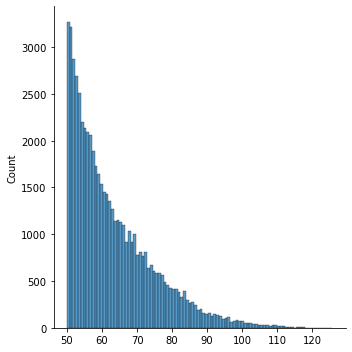

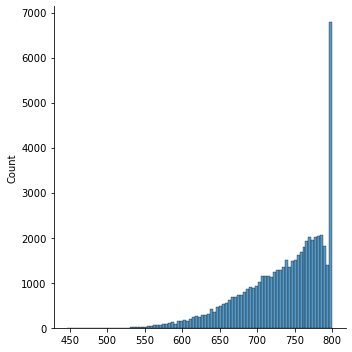

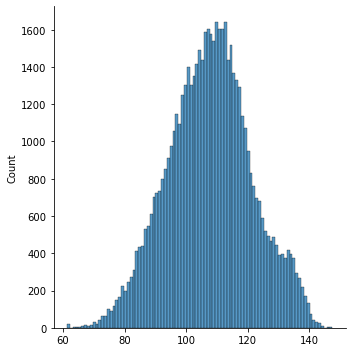

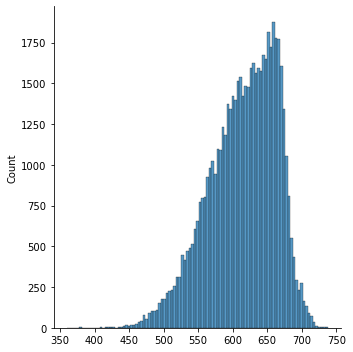

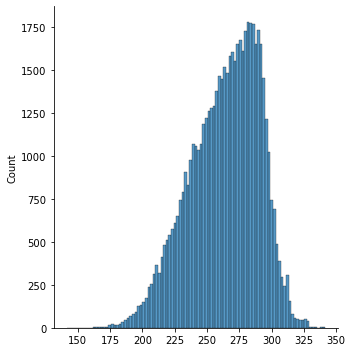

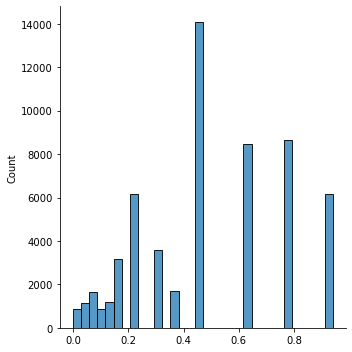

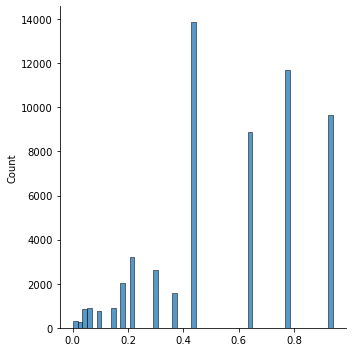

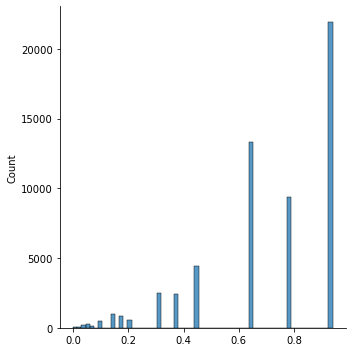

In [ ]:
featuregeneration = [("DistanciaMinima", DistanciaMinima() ),
                     ("DistanciaMaxima", DistanciaMaxima() ),
                     ("MediaDistMin", MediaDistanciasMinimas() ),
                     ("MediaDistMax", MediaDistanciasMaximas() ),
                     ("DistMediaCentroide", DistanciaMediaACentroide()),
                     ("Chi2x",Chi2x()),
                     ("Chi2y",Chi2y()),
                     ("Chi2Diagonal", Chi2Diagonal())]

scaler = [("MinMaxScaler", MinMaxScaler())]

pipegeneration = Pipeline(featuregeneration)
pipescaler = Pipeline(scaler)

"""
filepip = path+'pipeline1.txt'

if os.path.exists(filepip):
	X_train = np.loadtxt(filepip)
else:
"""

X_train = pipegeneration.fit_transform(X_train)
#np.savetxt(filepip,X_train)

for i in range(32, X_train.shape[1]):
    sns.displot(X_train[:,i], label=i)
    plt.show()

pipescaler.fit(X_train)
X_train = pipescaler.transform(X_train)


X_test = pipegeneration.fit_transform(X_test)     # Las características se deben ejecutar sobre el propio conjunto de test
X_test = pipescaler.transform(X_test)             # Pero la normalización se debe de realizar respecto a la hecha en el conjunto de entrenamiento

Vamos a comprobar además cuántas instancias no rechazan la hipótesis nula para los 3 tests estadísticos.

In [ ]:
X_train_uniform = X_train[(X_train[:,-3] >= 0.05) | (X_train[:,-2] >= 0.05) | (X_train[:,-1] >= 0.05)]

print(X_train_uniform.shape)

X_train_uniform = X_train[(X_train[:,-3] <= 0.05) | (X_train[:,-2] <= 0.05) | (X_train[:,-1] <= 0.05)]

print(X_train_uniform.shape)

(57561, 40)
(3595, 40)


In [ ]:
Xdf = pd.DataFrame(X_train)
#Xdf.describe()

Xdf.iloc[:,32:].describe()

,32,33,34,35,36,37,38,39
count,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000,57593.000000
mean,0.172936,0.818401,0.539135,0.673285,0.612265,0.521013,0.605540,0.751090
std,0.154436,0.152519,0.157819,0.129078,0.133719,0.285097,0.283257,0.260702
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.051298,0.724302,0.432419,0.588299,0.520803,0.222927,0.471854,0.687233
50%,0.128210,0.852516,0.540995,0.689601,0.628636,0.472229,0.686985,0.828998
75%,0.254179,0.942167,0.642092,0.775973,0.715920,0.828984,0.828863,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Reducción de la escala de la variable a predecir: Debido a que la variable a predecir tiene una escala mucho mayor que la de los atributos que usamos para predecir, lo que haremos será reducir su escala para que los pesos que se encuentren en los modelos que deban hallarse no tengan que ser de forma intrínseca tan grandes y que algunos modelos les cueste llegar hasta ellos. Además, los parámetros de regularización tendrán un ajuste más complicado en estos casos. Por tanto pasaremos de W (Vatios) a MW (Megavatios)

In [ ]:
y_train = y_train/1e6
y_test = y_test/1e6
print("Nuevos valores de la variable a predecir")
pd.DataFrame(y_train).describe()

Nuevos valores de la variable a predecir


,0
count,57593.000000
mean,1.486298
std,0.023074
min,1.361962
25%,1.471046
50%,1.487336
75%,1.504315
max,1.536347


Frecuencias relativas de las potencias totales por rangos de los valores de entrenamiento


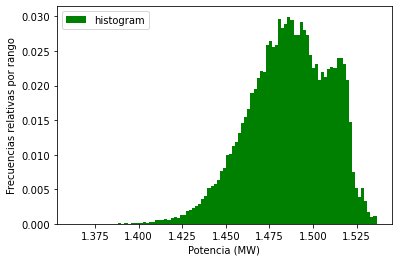

Frecuencias relativas de las potencias totales por rangos de los valores de test


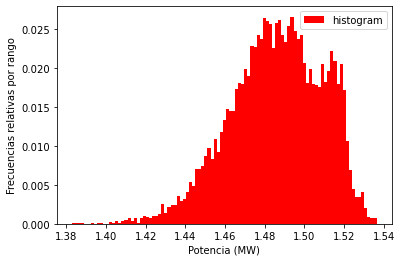

In [ ]:
print("Frecuencias relativas de las potencias totales por rangos de los valores de entrenamiento")

bin = np.linspace(np.min(y_train),np.max(y_train), 100)
bin_heights, bin_borders, _ = plt.hist(y_train, bins=bin, label='histogram', color='green', weights=np.zeros_like(y_train) + 1. / y_train.shape[0])
bin_heights = bin_heights / sum(bin_heights)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.legend()
plt.ylabel("Frecuencias relativas por rango")
plt.xlabel("Potencia (MW)")
plt.show()

print("Frecuencias relativas de las potencias totales por rangos de los valores de test")

bin = np.linspace(np.min(y_test),np.max(y_test), 100)
bin_heights, bin_borders, _ = plt.hist(y_test, bins=bin, label='histogram', color='red', weights=np.zeros_like(y_test) + 1. / y_test.shape[0])
bin_heights = bin_heights / sum(bin_heights)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.legend()
plt.ylabel("Frecuencias relativas por rango")
plt.xlabel("Potencia (MW)")
plt.show()

In [ ]:
print("---Análisis de valores perdidos---")
if Xdf.isnull().sum().to_numpy().sum():        #Comprueba si hay ALGÚN valor perdido en todo el dataset
    print("Número de valores perdidos por cada atributo: ", x_train.isnull().sum().to_numpy())
else:
    print("No hay valores perdidos en el dataset")


---Análisis de valores perdidos---
No hay valores perdidos en el dataset


---Gráfico nube de puntos del CETO  1 ---


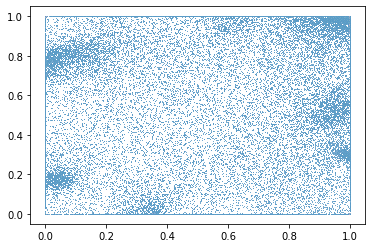

---Gráfico nube de puntos del CETO  2 ---


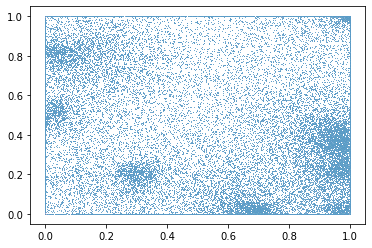

---Gráfico nube de puntos del CETO  3 ---


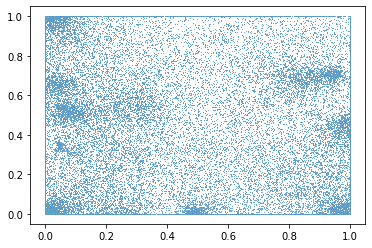

---Gráfico nube de puntos del CETO  4 ---


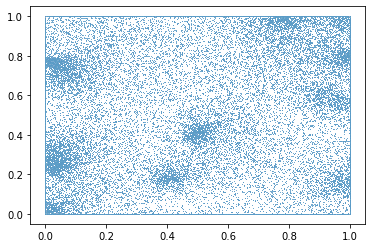

---Gráfico nube de puntos del CETO  5 ---


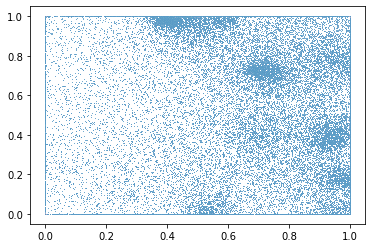

---Gráfico nube de puntos del CETO  6 ---


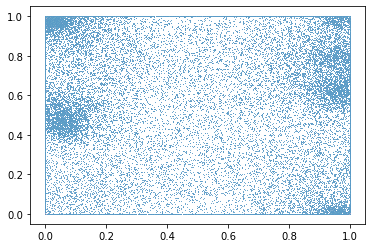

---Gráfico nube de puntos del CETO  7 ---


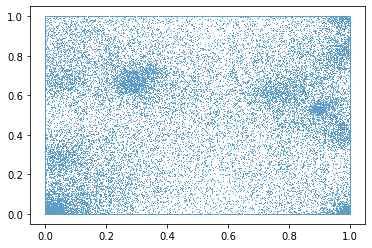

---Gráfico nube de puntos del CETO  8 ---


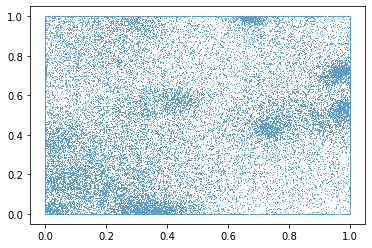

---Gráfico nube de puntos del CETO  9 ---


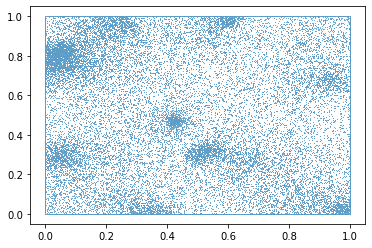

---Gráfico nube de puntos del CETO  10 ---


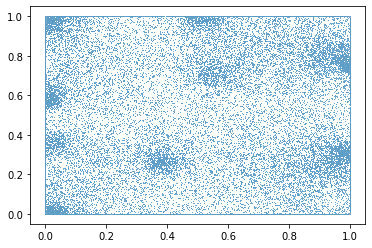

---Gráfico nube de puntos del CETO  11 ---


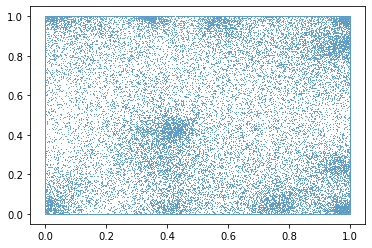

---Gráfico nube de puntos del CETO  12 ---


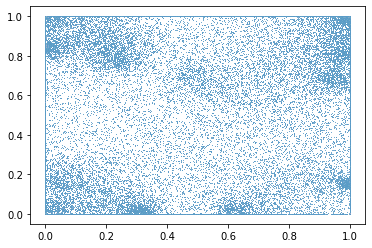

---Gráfico nube de puntos del CETO  13 ---


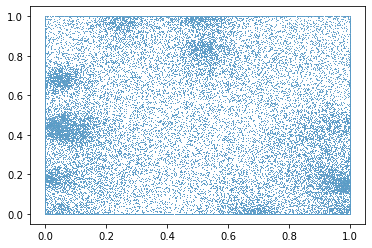

---Gráfico nube de puntos del CETO  14 ---


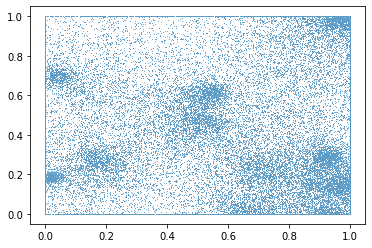

---Gráfico nube de puntos del CETO  15 ---


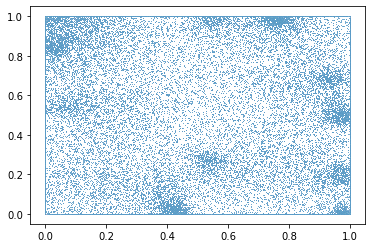

---Gráfico nube de puntos del CETO  16 ---


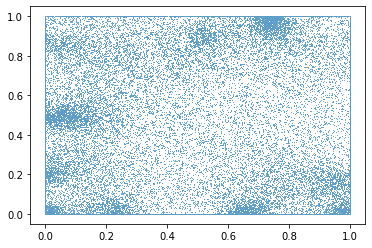

---Gráfico nube de puntos del CETO  1 ---
---Gráfico nube de puntos del CETO  2 ---
---Gráfico nube de puntos del CETO  3 ---
---Gráfico nube de puntos del CETO  4 ---
---Gráfico nube de puntos del CETO  5 ---
---Gráfico nube de puntos del CETO  6 ---
---Gráfico nube de puntos del CETO  7 ---
---Gráfico nube de puntos del CETO  8 ---
---Gráfico nube de puntos del CETO  9 ---
---Gráfico nube de puntos del CETO  10 ---
---Gráfico nube de puntos del CETO  11 ---
---Gráfico nube de puntos del CETO  12 ---
---Gráfico nube de puntos del CETO  13 ---
---Gráfico nube de puntos del CETO  14 ---
---Gráfico nube de puntos del CETO  15 ---
---Gráfico nube de puntos del CETO  16 ---


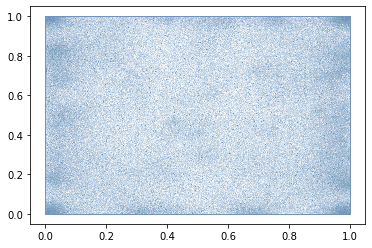

In [ ]:
for i in range(16):
  print("---Gráfico nube de puntos del CETO ", i+1, "---")
  sns.scatterplot(x=X_train[:,i], y=X_train[:,i+16], palette="coolwarm", s=1)
  plt.show()

for i in range(16):
  print("---Gráfico nube de puntos del CETO ", i+1, "---")
  sns.scatterplot(x=X_train[:,i], y=X_train[:,i+16], color='#3A76AF', s=0.05 )
plt.show()

---Matriz de correlación de los atributos iniciales---


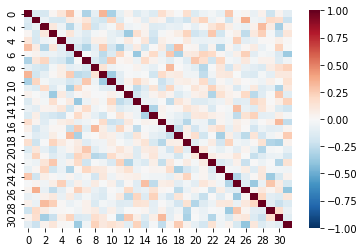

---Matriz de correlación de todos los atributos---


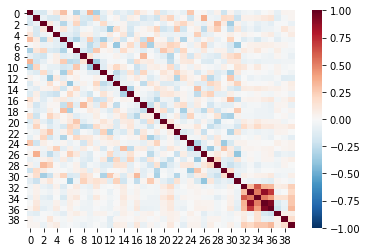

In [ ]:
print("---Matriz de correlación de los atributos iniciales---")
corrMatrix = Xdf.iloc[:,:32].corr()
sns.heatmap(corrMatrix, vmin=-1, vmax=1, cmap="RdBu_r")
plt.show()

print("---Matriz de correlación de todos los atributos---")
corrMatrix = Xdf.corr()
sns.heatmap(corrMatrix, vmin=-1, vmax=1, cmap="RdBu_r")
plt.show()


In [ ]:
"""
print("-> Con TSNE sólo con los atributos originales 2D")
tsne = TSNE()
tsne_results = tsne.fit_transform(Xdf.iloc[:,:32])
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=y_train, palette="coolwarm")
plt.show()
"""
"""
print("-> Con TSNE sólo con los atributos originales 3D")
tsne = TSNE(n_components=3)
tsne_results = tsne.fit_transform(Xdf.iloc[:,:32])


# Creamos el plot y mostramos

ax = plt.figure(figsize=(15,9)).gca(projection='3d')
scatter=ax.scatter(xs=tsne_results[:,0], ys=tsne_results[:,1], zs=tsne_results[:,2], c=y_train, cmap=plt.get_cmap('coolwarm'), s=5)
ax.legend(handles = scatter.legend_elements()[0], title = "Potencia", loc='lower left')
plt.show()
"""

'\nprint("-> Con TSNE sólo con los atributos originales 3D")\ntsne = TSNE(n_components=3)\ntsne_results = tsne.fit_transform(Xdf.iloc[:,:32])\n\n\n# Creamos el plot y mostramos\n\nax = plt.figure(figsize=(15,9)).gca(projection=\'3d\')\nscatter=ax.scatter(xs=tsne_results[:,0], ys=tsne_results[:,1], zs=tsne_results[:,2], c=y_train, cmap=plt.get_cmap(\'coolwarm\'), s=5)\nax.legend(handles = scatter.legend_elements()[0], title = "Potencia", loc=\'lower left\')\nplt.show()\n'

In [ ]:
class RBFNetworkRegressor(BaseEstimator, RegressorMixin):
    """
       Regresor de red de funciones (gaussianas) de base radial.
       Uso de un modelo Ridge para ajustar los pesos del modelo final.
    """

    def __init__(self, k = 16, alpha = 1.0, batch_size = 128,
                 random_state = None, gamma=1):
        """
          Instancia un regresor con los hiperparámetros:
             - k:             número de centros a elegir.
             - alpha:         constante de regularización.
             - batch_size:    tamaño del batch para el clustering no supervisado.
             - random_state:  semilla aleatoria.ç
             - gamma:         Parámetro para controlar la escala de r
        """

        self.k = k
        self.alpha = alpha
        self.batch_size = batch_size
        self.random_state = random_state
        self.centers = None                 # Centroides
        self.r = None               
        self.gamma = gamma          

    def generar_centros_kmeans(self, X):
        """
          Elección de k centros a partir del algoritmo de K-Medias
        """

        init_size = 3 * self.k if 3 * self.batch_size <= self.k else None

        kmeans = MiniBatchKMeans(
            n_clusters = self.k,
            batch_size = self.batch_size,
            init_size = init_size,
            random_state = self.random_state)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

    def calcular_radio(self):
        """
          Cálculo del radio para aplicar en el kernel
        """

        # Calculamos la media de las distancias mínimas entre los centros
        mindists = np.zeros(self.centers.shape[1]) #Aquí almacenaremos las distancias entre cada par de CETOs
        
        for i in range(self.centers.shape[0]):
          min = float('inf')
          for j in range(self.centers.shape[0]):
            curdist = norm(self.centers[i]-self.centers[j])
            if curdist < min and not i == j:
              min = curdist
          mindists[i] = min

        self.r = self.gamma * mindists    # Nuestro sigma de la función gaussiana
       

    def _transform_rbf(self, X):
        """
          Aplicación del kernel RBF.
        """

        ret = []
        for i in range(self.centers.shape[0]):
          ret.append(rbf_kernel(X, self.centers[i].reshape(-1,1).T , 1 / (2 * self.r[i] ** 2)))
        
        return np.array(ret).T.reshape(X.shape[0], self.centers.shape[0])

    def fit(self, X, y):
        """
          Entrena el modelo.
        """

        self.model = Ridge(alpha = self.alpha,
                           random_state = self.random_state)

        # Obtenemos los k centros y el radio para el kernel 
        self.generar_centros_kmeans(X)
        self.calcular_radio()

        # Transformamos los datos a través de nuestro kernel y centros
        Z = self._transform_rbf(X)

        # Entrenamos
        self.model.fit(Z, y)

        # Guardamos los coeficientes obtenidos
        self.intercept_ = self.model.intercept_
        self.coef_ = self.model.coef_

        return self

    def score(self, X, y = None):
        Z = self._transform_rbf(X)

        return self.model.score(Z, y)

    def predict(self, X):
        Z = self._transform_rbf(X)

        return self.model.predict(Z)

    def decision_function(self, X):
        Z = self._transform_rbf(X)

        return self.model.decision_function(Z)


In [ ]:
np.logspace(-2,-4,3)

array([0.01  , 0.001 , 0.0001])

In [ ]:
# Modelos de aprendizaje y parámetros


maxIter = 2000
randomstate = 777
LinRegSpace = np.logspace(-4, 1, 6)
MLPSpace = np.logspace(-4, 1, 6)

# Se ha ejecutado con los siguientes valores:
# SVRCSpace = np.logspace(-4,-2,3)
# SVRepsilonSpace = np.logspace(-4,-2,3)
# Para estos valores, los mejores resultados obtenidos han sido
# 1e-3 en ambos valores. Por cuestiones duras de eficiencia, se han dejado sólo
# estos valores de cara a una posterior ejecución
maxIterSVR = 8000
SVRCSpace = [1e-3]      
SVRepsilonSpace = [1e-3]

BoostSpace = [0.5, 0.7, 0.9]
RFSpace = [50, 100, 200]
kSpace = np.logspace(4,6,3,base=2).astype('int')
gammaSpace = np.linspace(1,3,3)
alpha = np.logspace(-2,0,3)

algs_and_params = [
                    #Regresión lineal sólo car. originales
                    [{'Model': [Ridge(max_iter=maxIter, random_state=randomstate)], #Modelos y parámetros para primer pipeline
                        "Model__alpha": LinRegSpace}],
                   
                   #Regresión lineal con todas las características
                    [{'Model': [Ridge(max_iter=maxIter, random_state=randomstate)], #Modelos y parámetros para primer pipeline
                        "Model__alpha": LinRegSpace}],
                    
                   #Perceptrón multicapa
                    [{'Model': [MLPRegressor(hidden_layer_sizes=(100,100), activation='relu', solver="sgd", max_iter=200, 
                                             learning_rate='adaptive', learning_rate_init=1e-2,
                                             random_state=randomstate, early_stopping=True)],
                        "Model__alpha": MLPSpace}], #La regularización es L2 de forma implícita
                    
                    #SVR, con kernel lineal
                    [{'Model': [SVR(kernel='poly', max_iter = maxIterSVR)],
                        "Model__C": SVRCSpace,
                        "Model__epsilon": SVRepsilonSpace}],

                    #AdaBoost
                    [{'Model': [AdaBoostRegressor(n_estimators=100, loss='linear', random_state=randomstate)],
                        "Model__learning_rate": BoostSpace}],
                   
                    #Random Forest
                    [{'Model': [RandomForestRegressor(max_depth=16, max_features='sqrt', n_jobs=-1)],
                        "Model__n_estimators": RFSpace}],

                     #Funciones de base radial
                    [{'Model': [RBFNetworkRegressor(batch_size=128)],
                        "Model__k": kSpace,
                        "Model__gamma": gammaSpace,
                        "Model__alpha": alpha}]

                   ]

In [ ]:
print(X_train.shape)
print(y_train.shape)
# Ejecutamos Cross-Validation para encontrar el mejor modelo
print("Ejecutando Cross-Validation y el fit para la selección del mejor modelo...")
start = default_timer()

pipe = Pipeline([('Model', AdaBoostRegressor())])


tiempo = []
best_models = []
best_params = []
results = []
for i in range(len(algs_and_params)):
  start = default_timer()
  best_model = GridSearchCV(pipe, 
                algs_and_params[i], 
                scoring=['neg_mean_squared_error',
                      'r2'],	
                refit='neg_mean_squared_error',
                return_train_score=True,			   
                cv=5,
                n_jobs=-1,
                verbose=3)
  
  if i == 0:
    best_model.fit(X_train[:,:32], y_train)
  else:
    best_model.fit(X_train, y_train)
  tiempo.append(default_timer() - start)
  best_models.append(best_model)
  best_params.append(best_model.best_params_['Model'])

"""


end = default_timer()
elapsed = end - start
print("Hecho. ({:.3f}min)\n".format(elapsed/60))

# Mostramos los resultados
print("\n ------------- MEJOR MODELO DE REGRESIÓN ------------- ")	
print("Parámetros:{}".format(best_model.best_estimator_))
print("Parámetros escogidos:{}".format(best_model.best_params_))
print("Número de variables usadas: {}".format(best_model.best_estimator_['reg'].coef_))
print("RMSE en CV: {:.3f}".format(np.sqrt(-best_model.best_score_)))
"""

(57593, 40)
(57593,)
Ejecutando Cross-Validation y el fit para la selección del mejor modelo...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


'\n\n\nend = default_timer()\nelapsed = end - start\nprint("Hecho. ({:.3f}min)\n".format(elapsed/60))\n\n# Mostramos los resultados\nprint("\n ------------- MEJOR MODELO DE REGRESIÓN ------------- ")\t\nprint("Parámetros:{}".format(best_model.best_estimator_))\nprint("Parámetros escogidos:{}".format(best_model.best_params_))\nprint("Número de variables usadas: {}".format(best_model.best_estimator_[\'reg\'].coef_))\nprint("RMSE en CV: {:.3f}".format(np.sqrt(-best_model.best_score_)))\n'

In [ ]:
arraytext = ['Regresión lineal originales', 'Regresión lineal', 'Perceptrón Multicapa', 'SVR', 'AdaBoost', 'Random Forest', 'Funciones de base radial']
minerrortrain = minerrortest = float('inf')

for i in range(len(algs_and_params)):

    print("\n>>> Resultados para ", arraytext[i], " <<<")
    print("-> Tiempo empleado en validación cruzada: {:.3f} minutos".format(tiempo[i] / 60.0))
    print('-> Mejores parámetros: {}.'.format(best_params[i]))
    print('-> RMSE en validación cruzada: {:.4f}'.format(np.sqrt(-best_models[i].best_score_)))
    if i == 0 or i == 1 :
      print('-> Coeficientes de la regresión lineal:{}'.format(best_models[i].best_estimator_['Model'].coef_))

    if i == 0:
      y_pred = best_models[i].predict(X_train[:,:32])
    else:
      y_pred = best_models[i].predict(X_train)
    print(X_train.shape)
    print(y_train.shape)
    print(y_pred)
    errortrain = np.sqrt(mean_squared_error(y_train, y_pred))
    if errortrain < minerrortrain:
        minerrortrain = errortrain
        minindextrain = i
    print("-> RMSE en entrenamiento: {:.4f}".format(errortrain))
    print('-> R2 en entrenamiento: {:.4f}'.format(r2_score(y_train, y_pred)))

    if i == 0:
      y_pred = best_models[i].predict(X_test[:,:32])
    else:
      y_pred = best_models[i].predict(X_test)
    errortest = np.sqrt(mean_squared_error(y_test, y_pred))
    if errortest < minerrortest:
        minerrortest = errortest
        minindextest = i
    print("-> RMSE en test: {:.4f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
    print('-> R2 en test: {:.4f}'.format(r2_score(y_test, y_pred)))



print("El mejor modelo en entrenamiento (menor RSME) ha sido encontrado utilizando el ", arraytext[minindextrain])

if minindextrain == minindextest:
    print("El mejor modelo en test ha sido también el mismo modelo")
else:
    print("El mejor modelo en test es sin embargo el modelo obtenido con el ", arraytext[minindextest])
"""
stop()
print("---Si entrenamos con todos los datos usando el mejor preprocesado y modelo---")
X_train.append(x_test)
y_train.append(y_test)
pipe = Pipeline(preprocfuns[minindextest]())
pipe.fit(X_train)
X_train_pipe = pipe.transform(X_train)
model = best_models[minindextest].best_params_['Model']
model.fit(X_train, y_train)
print("Realizando validación cruzada 10 folds, RMSE en validación: ", np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))))
print("Entrenando con todos los datos, RMSE en entrenamiento: ", np.sqrt(mean_squared_error(model.predict(X_train), y_train)))

print("\nFin de la ejecución")
"""
print("---Fin de la ejecución---\n")


>>> Resultados para  Regresión lineal originales  <<<
-> Tiempo empleado en validación cruzada: 0.051 minutos
-> Mejores parámetros: Ridge(alpha=10.0, max_iter=2000, random_state=777).
-> RMSE en validación cruzada: 0.0215
-> Coeficientes de la regresión lineal:[ 1.28569980e-03  4.98749663e-03 -4.99763883e-03 -2.03799604e-03
  3.94203080e-03 -7.32944135e-03  2.41091512e-03 -6.50724494e-04
 -1.33177342e-03 -2.02412420e-03 -1.00993160e-03 -6.59586073e-04
 -9.58335073e-03  4.36721515e-04  5.62868152e-03 -6.01015080e-03
  7.26195544e-03 -1.91724405e-03 -2.32103347e-03 -3.49341517e-03
  1.70776766e-03  1.01292048e-02 -2.51959976e-03 -4.94785975e-03
  3.66367330e-03  1.55775265e-03 -2.09922107e-04  6.80504742e-03
 -4.22736565e-03 -3.54847618e-03  4.73950759e-03 -3.20582052e-05]
(57593, 40)
(57593,)
[1.49281297 1.49162002 1.49110316 ... 1.47460563 1.49070047 1.4937698 ]
-> RMSE en entrenamiento: 0.0215
-> R2 en entrenamiento: 0.1328
-> RMSE en test: 0.0217
-> R2 en test: 0.1222

>>> Resultad

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
  Fuente:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
  
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing fit and predict methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:CV splitter,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:StratifiedKFold used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:KFold is used.

        Refer :ref:User Guide <cross_validation> for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:joblib.parallel_backend context.
        ``-1`` means using all processors. See :term:Glossary <n_jobs>
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)

    # Transformamos los scores en función del error cuadrático medio  
    train_scores = np.sqrt(-train_scores)
    test_scores = np.sqrt(-test_scores)                    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

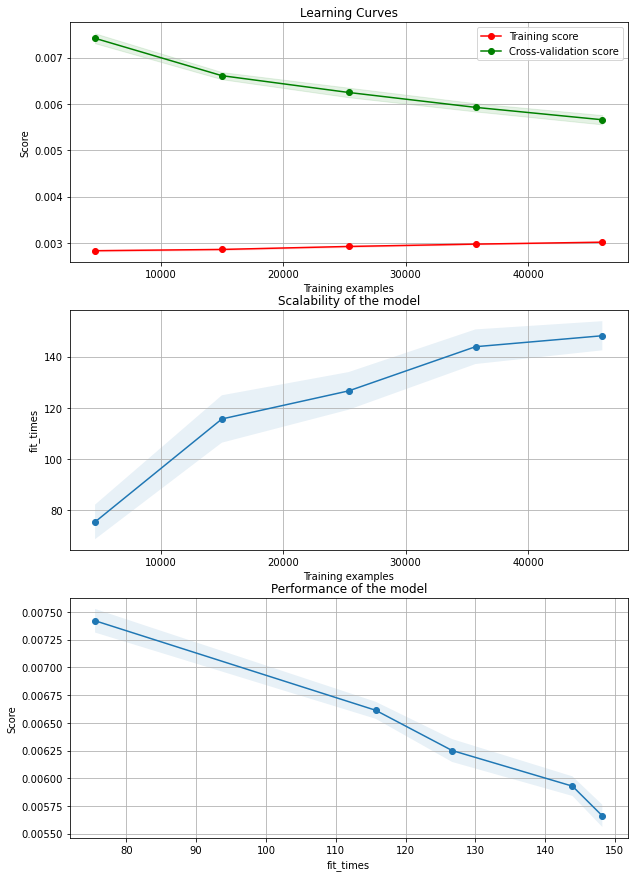

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plot_learning_curve(best_models[minindextest], 'Learning Curves', X_train, y_train, axes=axes, cv = 5, n_jobs=-1)
plt.show()

RMSE en train: 0.003
R2 en train: 0.983
[1.49087762 1.51676712 1.49899676 ... 1.44463124 1.4866944  1.51159176]
[1.49132463 1.51799822 1.49986907 ... 1.44173659 1.48504659 1.51278543]


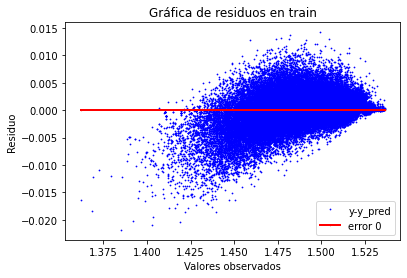

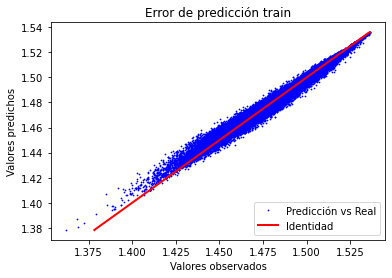

RMSE en test: 0.005
R2 en test: 0.945
[1.5162975  1.51233448 1.47952921 ... 1.45398178 1.43963309 1.44961591]
[1.49132463 1.51799822 1.49986907 ... 1.44173659 1.48504659 1.51278543]


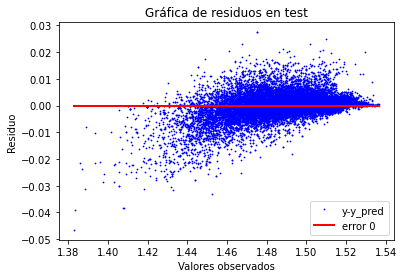

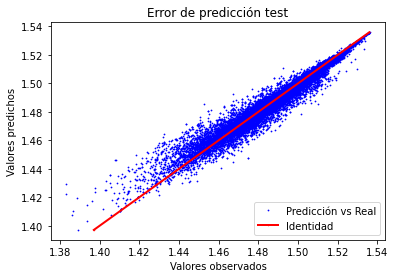

In [ ]:
for name, X, y, name in [("training", X_train, y_train, 'train'), ("test", X_test, y_test, 'test')]:
    y_pred = best_models[minindextest].predict(X)
    print("RMSE en {}: {:.3f}".format(name, (np.sqrt(mean_squared_error(y, y_pred)))))
    print("R2 en {}: {:.3f}".format( name, r2_score(y, y_pred)))
  
    print(y_pred)
    print(y_train)
    # Creamos el plot de RESIDUOS
    fig, ax = plt.subplots()
      
    ax.plot(y, y-y_pred, 'bo-', linewidth=0, ms=0.75, label='y-y_pred')
    ax.plot([min(y), max(y)],[0,0], 'ro-', linewidth=2, ms=0.5, label='error 0')
    ax.set(title='Gráfica de residuos en '+str(name))
    ax.set_xlabel('Valores observados')
    ax.set_ylabel('Residuo')
    ax.legend(loc='lower right', shadow=False)
    
    plt.show()
    
    
    # Creamos el plot PREDICCIÓN VS REAL
    fig, ax = plt.subplots()
      
    ax.plot(y, y_pred, 'bo-', linewidth=0, ms=0.75, label='Predicción vs Real')
    ax.plot([max(min(y),min(y_pred)), min(max(y),max(y_pred))],[max(min(y),min(y_pred)), min(max(y),max(y_pred))], 'ro-', linewidth=2, ms=0.5, label='Identidad')
    ax.set(title='Error de predicción '+str(name))
    ax.set_xlabel('Valores observados')
    ax.set_ylabel('Valores predichos')
    ax.legend(loc='lower right', shadow=False)

    plt.show()

[1.]


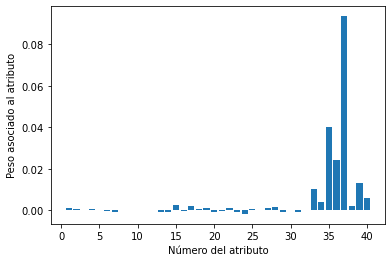

In [ ]:
pesos = [ 1.07379869e-03,  7.87559049e-04,  2.61783723e-04,  7.95175038e-04,
  3.33727099e-04, -3.28745176e-04, -8.12812497e-04,  1.98531982e-04,
  1.41510010e-04,  3.45870754e-04,  9.46068129e-05,  3.25965922e-04,
 -5.07098155e-04, -6.23780502e-04,  2.74622002e-03, -2.48875523e-04,
  2.05125540e-03,  8.91825775e-04,  1.09566431e-03, -8.20629593e-04,
 -2.23073843e-05,  1.37623224e-03, -5.97086384e-04, -1.65091458e-03,
  4.82577195e-04,  3.67573152e-04,  1.03192110e-03,  1.44662765e-03,
 -7.97422227e-04,  4.61735339e-05, -7.26298979e-04,  1.72964373e-04,
  1.04299163e-02,  4.01842467e-03,  4.03132596e-02,  2.42084193e-02,
  9.35376169e-02,  2.15294113e-03,  1.30902095e-02,  5.98624347e-03]
 
print(np.linspace(1,40,1))
plt.bar(np.linspace(1,40,40), pesos)
plt.xlabel("Número del atributo")
plt.ylabel("Peso asociado al atributo")
plt.show()